In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

Create training and test set with 500 examples of classes 5 and 8 respectively and change labels to 0 and 1. At the same time flip 30% of the labels.

In [3]:
train_set = [ex for ex in train_dataset if ex[1]==5][:500] + [ex for ex in train_dataset if ex[1]==8][:500]
test_set = [ex for ex in test_dataset if ex[1]==5][:500] + [ex for ex in test_dataset if ex[1]==8][:500]

In [4]:
train_set_01_images = []
test_set_01_images = []
train_set_01_labels = []
test_set_01_labels = []
num_flips = 500//3 #num_flips=0 to have no flips
for i,ex_tr in enumerate(train_set):
    ex_tr = list(ex_tr)
    if ex_tr[1]==5:
        if i<num_flips:
            ex_tr[1]=1
        else: 
            ex_tr[1]=0
    else: 
        if i<num_flips+500:
            ex_tr[1]=0
        else: 
            ex_tr[1]=1
    train_set_01_images.append(ex_tr[0])
    train_set_01_labels.append(ex_tr[1])
    
for ex_te in test_set:
    ex_te = list(ex_te)
    if ex_te[1]==5:
        ex_te[1]=0
    else: 
        ex_te[1]=1
    test_set_01_images.append(ex_te[0])
    test_set_01_labels.append(ex_te[1])    
    
train_set_01_images = torch.stack(train_set_01_images)
train_set_01_images = train_set_01_images.view(-1, 28*28)
test_set_01_images = torch.stack(test_set_01_images)
test_set_01_images = test_set_01_images.view(-1, 28*28)
train_set_01_labels = torch.tensor(train_set_01_labels)
test_set_01_labels = torch.tensor(test_set_01_labels)

# shuffle training set
n_sample = len(train_set_01_images)
np.random.seed(0)
order = np.random.permutation(n_sample)
train_set_01_images = train_set_01_images[order]
train_set_01_labels = train_set_01_labels[order]

In [5]:
print("size train set:", train_set_01_images.shape) 
print("size test set:", test_set_01_images.shape)

size train set: torch.Size([1000, 784])
size test set: torch.Size([1000, 784])


### SUB-QUESTION 1, WHERE NO FEATURE MAP IS UTILIZED

In [6]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

In [7]:
def ApplyFeatures(train, test):
    FeatureMatrix = torch.relu(torch.randn(784, 784*2, dtype=torch.float))
    train = train @ FeatureMatrix
    test = test @ FeatureMatrix
    train -= train.mean(0)[None, :]
    train /= train.std(0)[None, :]
    test -= test.mean(0)[None, :]
    test /= test.std(0)[None, :]
    return train, test

In [10]:
def trainClassifier(num_epochs, learning_rate):

    model = LogisticRegressionModel(train_set_01_images.shape[1])
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    accTestList = []
    accTrainList = []

    for epoch in tqdm(range(num_epochs), "Epoch"):
        optimizer.zero_grad()
        outputs = model(train_set_01_images)
        loss = criterion(outputs, train_set_01_labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            outputTrain = model(train_set_01_images)
            predicted_labels_train = (outputTrain > 0.5).squeeze().float()  
            accTrain = (predicted_labels_train == train_set_01_labels).float().mean().item()
            accTrainList.append(accTrain)

            outputTest = model(test_set_01_images)
            predicted_labels_test = (outputTest > 0.5).squeeze().float()  
            accTest = (predicted_labels_test == test_set_01_labels).float().mean().item()
            accTestList.append(accTest)

    max_train_accuracy = max(accTrainList)
    max_train_accuracy_index = accTrainList.index(max_train_accuracy)

    max_test_accuracy = max(accTestList)
    max_test_accuracy_index = accTestList.index(max_test_accuracy)

    # Plotting Loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), accTrainList, marker='o')
    plt.title(f'Train Accuracy (Max: {max_train_accuracy:.4f} at Epoch {max_train_accuracy_index})')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), accTestList, marker='o', color='green')
    plt.title(f'Test Accuracy (Max: {max_test_accuracy:.4f} at Epoch {max_test_accuracy_index})')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

Epoch: 100%|██████████| 10000/10000 [00:15<00:00, 640.32it/s]


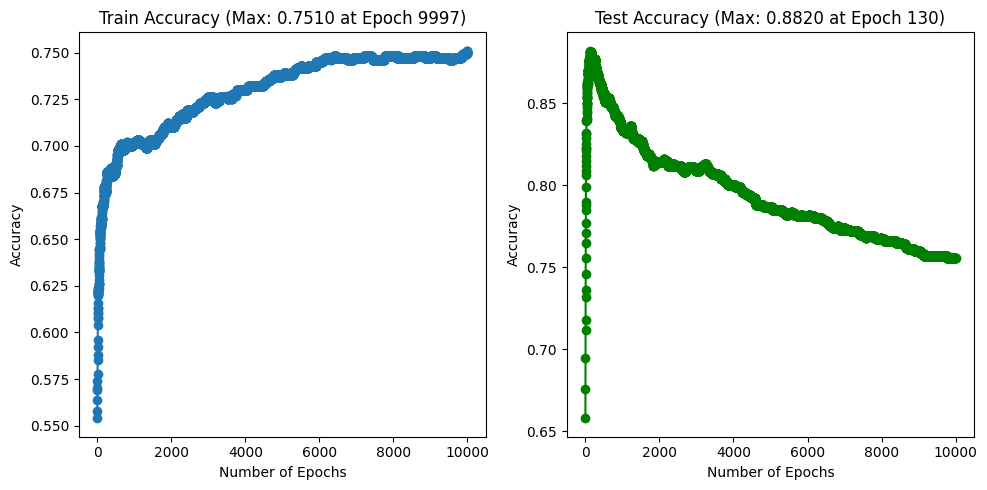

Epoch: 100%|██████████| 10000/10000 [00:22<00:00, 448.70it/s]


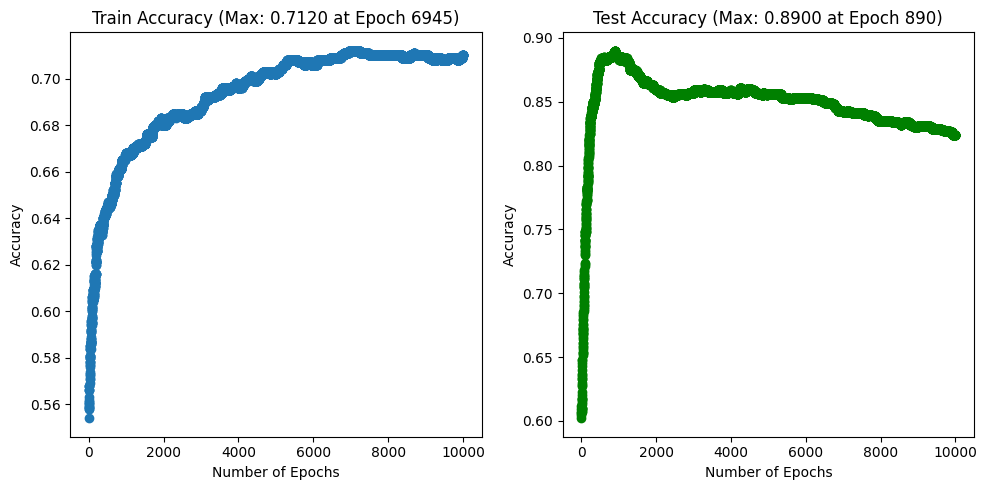

In [11]:
trainClassifier(num_epochs= 10000, learning_rate= 0.02)
train_set_01_images, test_set_01_images = ApplyFeatures(train_set_01_images, test_set_01_images)
trainClassifier(num_epochs= 10000, learning_rate= 0.001)

**As it can be seen from the plots, in the less-parametrized regime, we observe overfitting much more, it reduces the test accuracy therefore we should apply algorithmic regularization (early-stopping) so that we don't overfit. In the over-parametrized regime, we get higher test accuracy and less overfitting for the same number of epochs. This is because when the number of parameters are much higher than the size of the dataset, our model is less-sensitive the changes in the data.**